## Decision Trees
---

We are going to try and see if we can predict delay from our flight delay + weather dataset. Since decision trees are suitable for categorical variables and continuous variables, we will make a prediction of a continous variable. Meaning that we will use a regression based version of decisions trees. 

**Let's grab the merged dataset that we are going to use**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import math

pd.set_option('display.max_columns',99)

In [3]:
data_path = os.path.join('..','data','flights_weather.csv')

# read the dataset into a dataframe (car)
# there are some columns which get read in as the wrong datatype,
# so we want to keep them as strings
dtypes = {
    'ORIGIN_AIRPORT': 'str', 
    'DESTINATION_AIRPORT': 'str', 
    'IATA_CODE_x': 'str', 
    'origin_weather_station': 'str', 
    'IATA_CODE_y': 'str', 
    'destination_weather_station': 'str', 
    'OR_MAX': 'str', 
    'OR_MIN': 'str', 
    'OR_PRCP': 'str', 
    'DES_MAX': 'str', 
    'DES_MIN': 'str', 
    'DES_PRCP': 'str', 
    'OR_FRSHTT': 'str', 
    'DES_FRSHTT': 'str'
}
fw_df = pd.read_csv(data_path, dtype=dtypes, parse_dates=['DATE'])

In [4]:
fw_df.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,000000
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,000000,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,010000
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,000000,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,000000
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,000000,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,000000
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,000000,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000


### Let's clean things up a little bit
---
Let's get rid of the Unnamed column and add a new column called label which labels each as delayed
or not.

In [5]:
fw_df.drop('Unnamed: 0', axis=1, inplace=True)
fw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,000000
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,000000,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,010000
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,000000,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,000000
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,000000,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,000000
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,000000,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000



### We've got a lot of variables!
---
There is 75 columns, there. Let's create a correlation heatmap and use that
to select some strongly correlated variables, with which we can produce a 
pair plot to get a little more insight into interesting variable.
This way we can try to intelligently choose the variables to use as features for our decision tree model.

In [6]:
# label each record delayed or not based on weather
# if the delay is mostly caused by weather, then we consider it to be a weather delay
# if not then it's labeled as other, and if it falls within +- 10 min of the SCHEDULED_DEPARTURE then it's not
# considered delayed.
#fw_df.dropna(inplace=True)
fw_df['DELAY_TYPE'] = \
    fw_df[['AIR_SYSTEM_DELAY',
           'SECURITY_DELAY',
           'AIRLINE_DELAY',
           'LATE_AIRCRAFT_DELAY',
           'WEATHER_DELAY']].idxmax(axis=1)
fw_df['DELAY_TYPE'] = fw_df['DELAY_TYPE'].fillna('UNDETERMINED')

In [7]:
fw_df['DELAY_TYPE']

0              UNDETERMINED
1              UNDETERMINED
2              UNDETERMINED
3              UNDETERMINED
4              UNDETERMINED
5              UNDETERMINED
6              UNDETERMINED
7              UNDETERMINED
8              UNDETERMINED
9              UNDETERMINED
10             UNDETERMINED
11             UNDETERMINED
12             UNDETERMINED
13             UNDETERMINED
14             UNDETERMINED
15             UNDETERMINED
16             UNDETERMINED
17             UNDETERMINED
18             UNDETERMINED
19             UNDETERMINED
20             UNDETERMINED
21             UNDETERMINED
22             UNDETERMINED
23             UNDETERMINED
24             UNDETERMINED
25             UNDETERMINED
26             UNDETERMINED
27         AIR_SYSTEM_DELAY
28             UNDETERMINED
29             UNDETERMINED
                 ...       
5819049        UNDETERMINED
5819050        UNDETERMINED
5819051       AIRLINE_DELAY
5819052        UNDETERMINED
5819053        UNDET

In [9]:
# get the correlation of the dataset
t = fw_df[[
    'DEPARTURE_DELAY','WEATHER_DELAY',
    'OR_TEMP', 'DEPARTURE_TIME', 'SCHEDULED_DEPARTURE',
    'ORIGIN_AIRPORT', 'OR_PRCP', 'DELAY_TYPE'
]].copy()
t['OR_PRCP'].dropna(inplace=True)
t['OR_PRCP'] = t['OR_PRCP'].apply(lambda x: float(str(x)[:-1]))
corr = t.corr()

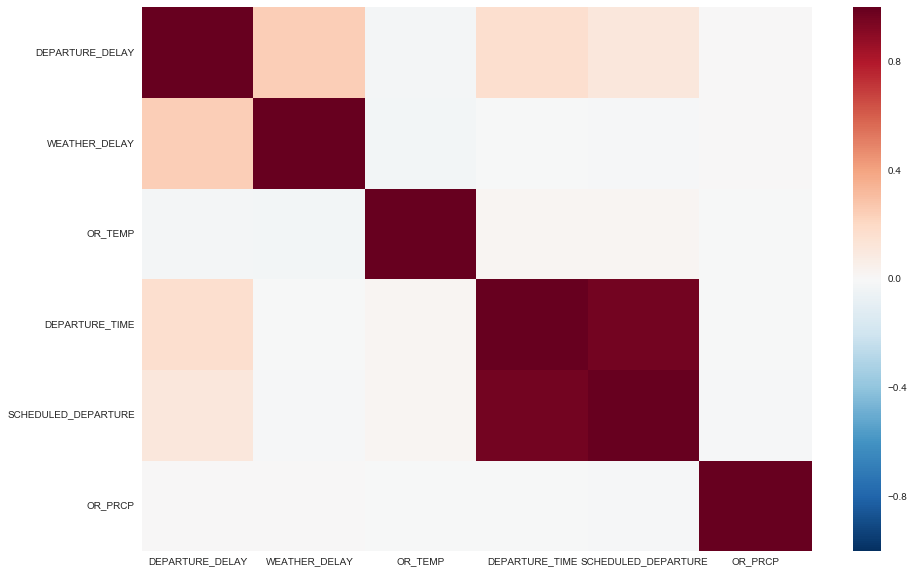

In [115]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax
)

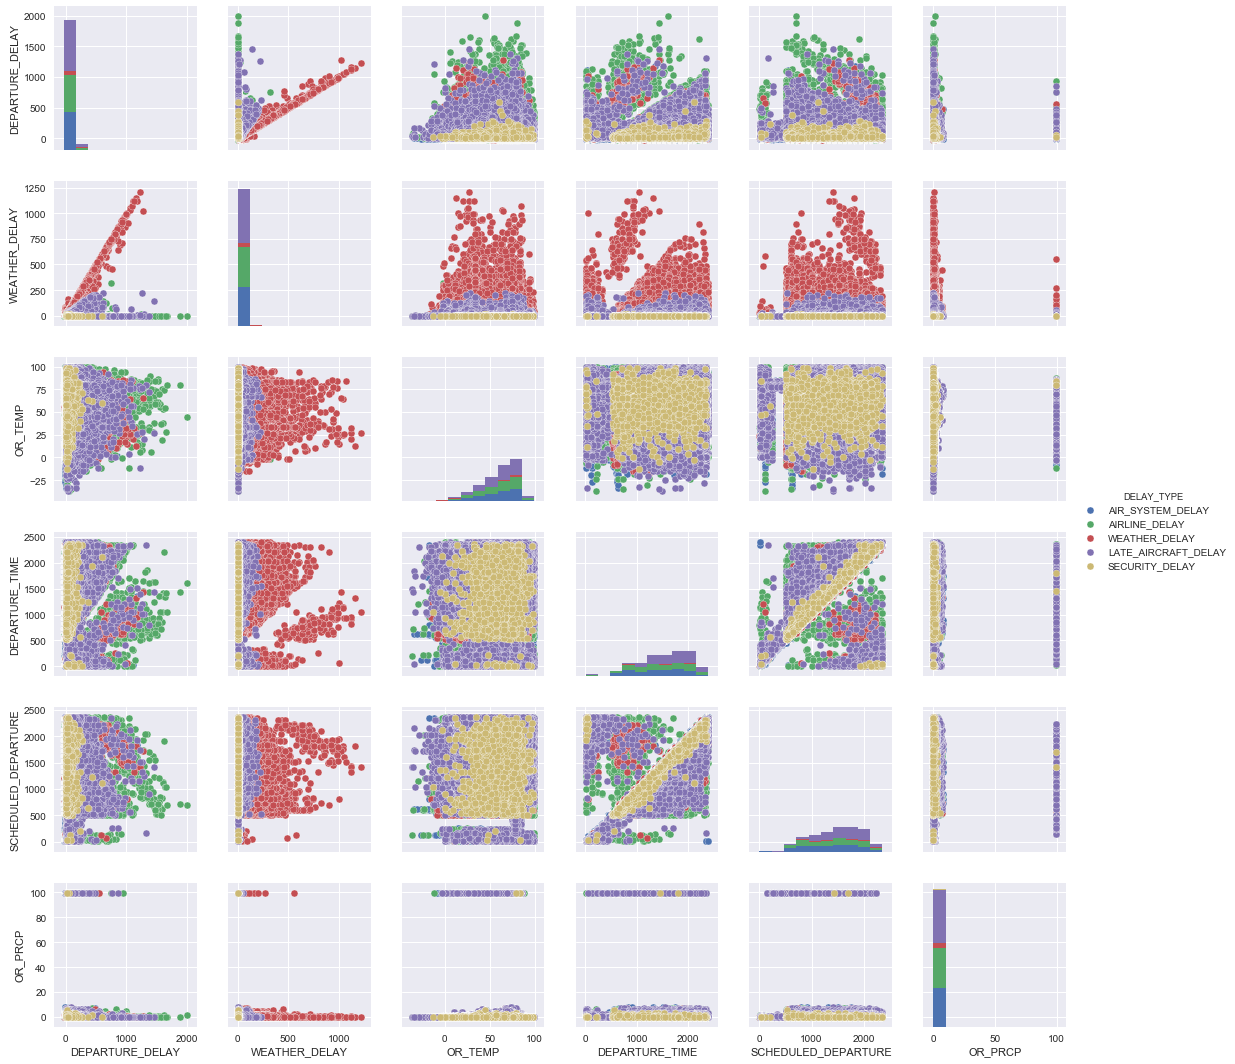

In [10]:
sns.pairplot(t.dropna(), hue='DELAY_TYPE')

It's a little difficult to get anything too interesting. We can see that it seems like our target
variable of DEPARTURE_DELAY, doesn't correlate strongly with any weather related variables. Which
is mostly what we want to look at. We can also try looking at DEPARTURE_DELAY vs SCHEDULED_DEPARTURE.

### Let's drop most of the columns and use only a few
---
Let's use DEPARTURE_DELAY, 